# CNN 316
Rather than partition train/validation sets, use different sets. 
Cut train set down to random LIMIT number of transcripts.
Use all of the validation set.
Use fit(shuffle) on the train set.

TO DO:
Save five best models to same directory to make it easy to delete.


In [24]:
TRAIN_NC_FILENAME='ncRNA.gc36.long.fasta'
TRAIN_PC_FILENAME='pcRNA.gc36.long.fasta'
VALID_NC_FILENAME='ncRNA.gc36.short.fasta'
VALID_PC_FILENAME='pcRNA.gc36.short.fasta'
#NC_FILENAME='ncRNA.tiny50.fasta'
#PC_FILENAME='pcRNA.tiny50.fasta'
#NC_FILENAME='ncRNA.gc34.processed.fasta'
#PC_FILENAME='pcRNA.gc34.processed.fasta'

MODEL_FILE='JUNK2'  # change this if you want to keep models
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
TRAIN_NC_FILENAME = DATAPATH+TRAIN_NC_FILENAME
TRAIN_PC_FILENAME = DATAPATH+TRAIN_PC_FILENAME
VALID_NC_FILENAME = DATAPATH+VALID_NC_FILENAME
VALID_PC_FILENAME = DATAPATH+VALID_PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=200
SPLITS=5
K=1
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=2
FILTERS=32
KERNEL=3
NEURONS=32
DROP=0.25
ACT="tanh"
MINLEN=201
MAXLEN=2000
LIMIT=5588    # This is the size of our smallest set (protein coding short)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [25]:
# Load our own tools
# TO DO: don't go to GitHub if the file is already local.
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [27]:
def compile_model(model):
    ## learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    #adam_default_learn_rate = 0.001
    #schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate = adam_default_learn_rate*10,
    #    decay_steps=10000, decay_rate=0.99, staircase=True)
    #alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])

    print("COMPILE...")
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    SHAPE=(MAXLEN,5)  # MAXLEN bases = time steps, 5 features = one hots
    clayer1 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same",
                                 input_shape=SHAPE)
    clayer2 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer3 = keras.layers.MaxPooling1D(2)
    clayer4 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer5 = keras.layers.Conv1D(FILTERS,KERNEL,activation=ACT,padding="same")
    clayer6 = keras.layers.MaxPooling1D(2)
    clayer7 = keras.layers.Flatten()

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt, input_shape=[1000])
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    cnn = keras.models.Sequential()
    cnn.add(clayer1)
    cnn.add(clayer2)
    cnn.add(clayer3)
    cnn.add(clayer4)
    cnn.add(clayer5)
    cnn.add(clayer6)
    cnn.add(clayer7)
    cnn.add(dlayer1)
    cnn.add(dlayer2)
    cnn.add(dlayer3)
    cnn.add(dlayer4)
    cnn.add(output_layer)
    mlpc = compile_model(cnn)
    return mlpc

Cross validation

In [28]:
def do_cross_validation(X_train,y_train,given_model,X_valid,y_valid):
    cv_scores = []
    fold=0
    # When not using ShuffleSplit, make sure to randomize train data.
    #splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    #for train_index,valid_index in splitter.split(X):
    while fold < SPLITS:
        fold += 1
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        es = keras.callbacks.EarlyStopping(monitor='val_loss',  
            patience=10, verbose=1)
        mc = keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')  
        mycallbacks = [es,mc]  
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks, shuffle=True,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  

    print()
    print("%d-way Cross Validation max %.2f%%, mean %.2f%% (+/- %.2f%%)" % 
          (fold, np.amax(cv_scores), np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [29]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
#model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 2000, 32)          512       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 2000, 32)          3104      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1000, 32)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1000, 32)          3104      
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 1000, 32)          3104      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 500, 32)           0         
___________________________________________________________

In [30]:
def load_data(nc_filename,pc_filename,limit=None):
  nc_seq=tools.load_fasta(nc_filename,0)
  pc_seq=tools.load_fasta(pc_filename,1)
  if limit is not None:
    # Choose a random subset of size = limit.
    # Side effect: randomizes the data order.
    nfrac=1.0*limit/len(nc_seq)
    pfrac=1.0*limit/len(pc_seq)
    if nfrac<1.0:
      nc_seq=nc_seq.sample(frac=nfrac)
    if pfrac<1.0:
      pc_seq=pc_seq.sample(frac=pfrac)
  train_set=pd.concat((nc_seq,pc_seq),axis=0)
  # May not need to slice by length if input files already sliced
  subset=tools.make_slice(train_set,MINLEN,MAXLEN)
  # randset=subset.sample(frac=1) # unneccessary with fit(shuffle)
  (X1,y1)=tools.separate_X_and_y(subset)
  # X1 is pandas df of ("list" of one sequence)
  X2=X1.to_numpy()  # numpy ndarray of ("list" of one sequence)
  X3=[elem[0] for elem in X2]  # numpy dnarray of str
  X4=tools.uniform_length(X3,MAXLEN)
  X5= [tools.one_hot(x) for x in X4]
  X6=np.asarray(X5)
  y6=y1.to_numpy()
  return X6,y6

print("Load train data from files.")
X_train,y_train = load_data(TRAIN_NC_FILENAME,TRAIN_PC_FILENAME,LIMIT)
print("X_train",X_train.shape)
print("Load valid data from files.")
X_valid,y_valid = load_data(VALID_NC_FILENAME,VALID_PC_FILENAME)
print("X_valid",X_valid.shape)

Load train data from files.
X_train (11176, 2000, 5)
Load valid data from files.
X_valid (18216, 2000, 5)


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 5s 11ms/step - loss: 0.6749 - accuracy: 0.6447 - val_loss: 0.6500 - val_accuracy: 0.6471
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets
Epoch 2/200
350/350 [==============================] - 4s 11ms/step - loss: 0.6213 - accuracy: 0.6731 - val_loss: 0.6225 - val_accuracy: 0.6863
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets
Epoch 3/200
350/350 [==============================] - 4s 11ms/step - loss: 0.6191 - accuracy: 0.6785 - val_loss: 0.6034 - val_accuracy: 0.6980
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets
Epoch 4/200
350/350 [==============================] - 4s 11ms/step - loss: 0.5829 - accuracy: 0.7056 - val_loss: 0.6114 - val_accuracy: 0.6944
Epoch 5/200
350/350 [==============================] - 4s 12ms/step - loss: 0.5949 - accuracy: 0.6903 - val_loss: 0.6281

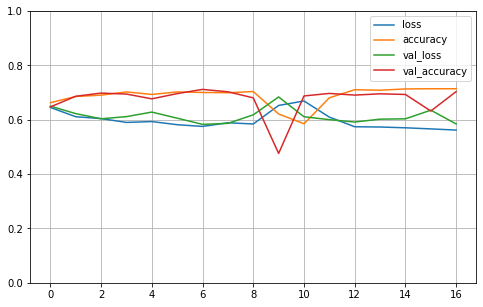

accuracy: 71.16%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 5s 11ms/step - loss: 0.6417 - accuracy: 0.6563 - val_loss: 0.5686 - val_accuracy: 0.7070
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets
Epoch 2/200
350/350 [==============================] - 4s 11ms/step - loss: 0.5943 - accuracy: 0.6907 - val_loss: 0.6251 - val_accuracy: 0.6722
Epoch 3/200
350/350 [==============================] - 4s 11ms/step - loss: 0.5599 - accuracy: 0.7153 - val_loss: 0.5755 - val_accuracy: 0.7140
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets
Epoch 4/200
350/350 [==============================] - 4s 11ms/step - loss: 0.5689 - accuracy: 0.7052 - val_loss: 0.6033 - val_accuracy: 0.6836
Epoch 5/200
350/350 [==============================] - 4s 11ms/step - loss: 0.5653 - accuracy: 0.7098 - val_loss: 0.5669 - val_accuracy: 0.7145
INFO:tensorflow:Assets written to: /content/drive/My Drive/dat

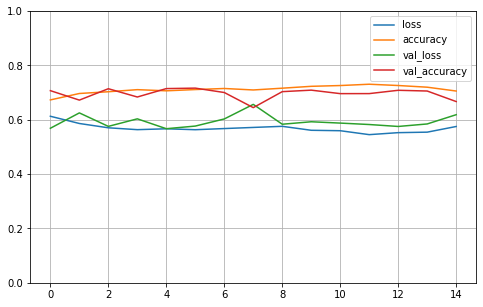

accuracy: 71.62%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 5s 12ms/step - loss: 0.6368 - accuracy: 0.6611 - val_loss: 0.5723 - val_accuracy: 0.7207
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets
Epoch 2/200
350/350 [==============================] - 4s 11ms/step - loss: 0.5839 - accuracy: 0.7034 - val_loss: 0.5811 - val_accuracy: 0.6915
Epoch 3/200
350/350 [==============================] - 4s 11ms/step - loss: 0.5794 - accuracy: 0.6986 - val_loss: 0.5862 - val_accuracy: 0.7052
Epoch 4/200
350/350 [==============================] - 4s 11ms/step - loss: 0.5643 - accuracy: 0.7184 - val_loss: 0.6009 - val_accuracy: 0.7004
Epoch 5/200
350/350 [==============================] - 4s 12ms/step - loss: 0.5810 - accuracy: 0.6987 - val_loss: 0.6752 - val_accuracy: 0.6266
Epoch 6/200
350/350 [==============================] - 4s 11ms/step - loss: 0.5590 - accuracy: 0.7089 - val_loss: 0.7239 - val_accuracy: 0.5791
Epoch

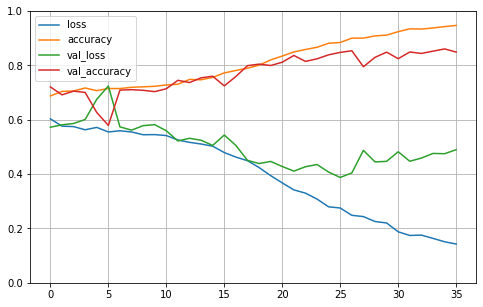

accuracy: 86.05%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 5s 12ms/step - loss: 0.6392 - accuracy: 0.6663 - val_loss: 0.6401 - val_accuracy: 0.6729
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets
Epoch 2/200
350/350 [==============================] - 4s 11ms/step - loss: 0.5990 - accuracy: 0.6840 - val_loss: 0.5831 - val_accuracy: 0.6911
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets
Epoch 3/200
350/350 [==============================] - 4s 12ms/step - loss: 0.5849 - accuracy: 0.6995 - val_loss: 0.5995 - val_accuracy: 0.6797
Epoch 4/200
350/350 [==============================] - 4s 12ms/step - loss: 0.5625 - accuracy: 0.7169 - val_loss: 0.5744 - val_accuracy: 0.7172
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets
Epoch 5/200
350/350 [==============================] - 4s 12ms/step - loss: 0.5792 - accuracy: 0.6997 - val_loss: 0.590

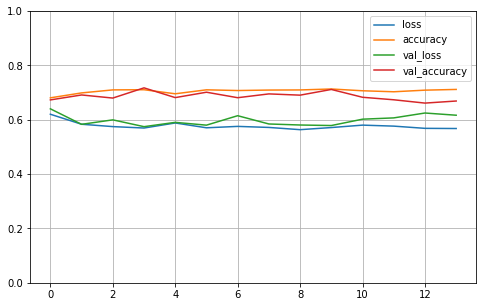

accuracy: 71.72%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 5s 12ms/step - loss: 0.6547 - accuracy: 0.6489 - val_loss: 0.6508 - val_accuracy: 0.6539
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets
Epoch 2/200
350/350 [==============================] - 4s 11ms/step - loss: 0.6086 - accuracy: 0.6918 - val_loss: 0.6564 - val_accuracy: 0.6556
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets
Epoch 3/200
350/350 [==============================] - 4s 12ms/step - loss: 0.6091 - accuracy: 0.6927 - val_loss: 0.6083 - val_accuracy: 0.6868
INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets
Epoch 4/200
350/350 [==============================] - 4s 12ms/step - loss: 0.6041 - accuracy: 0.6929 - val_loss: 0.6165 - val_accuracy: 0.6847
Epoch 5/200
350/350 [==============================] - 4s 11ms/step - loss: 0.5904 - accuracy: 0.7011 - val_loss: 0.613

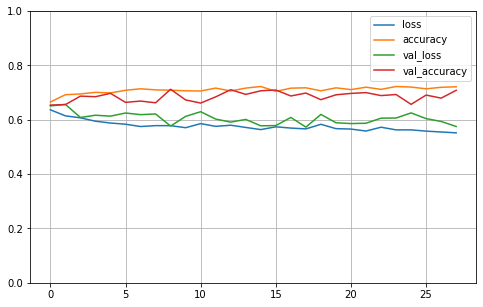

accuracy: 71.20%

5-way Cross Validation max 86.05%, mean 74.35% (+/- 5.85%)
Done


In [31]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model,X_valid,y_valid)  
print ("Done")